# Data loading an prep

In [2]:
from langchain.docstore.document import Document
from datasets import load_dataset
import pandas as pd

df = pd.read_csv(
    "./data/annonces_aveccaracteristiques_preprocesse.csv"
)

# Define a helper function to convert a dataset entry to a Document
# This object has two main components: page_content and metadata.

def entry_to_document(entry):
    """
    Convert a single dataset entry to a Document object. every dataset entry is converted into a Document object in a consistent manner. This consistency is crucial for downstream processing...
    Args:
        entry (dict): A single entry from the dataset.
        
    page_content: contains a formatted string that includes all the relevant information from the dataset entry
    """
    return Document(
        page_content="\n".join([
            f"ID: {entry['ID']}",
            f"Titre: {entry['Titre']}",
            f"Prix: {entry['Prix']}",
            f"Localisation: {entry['Localisation']}",
            f"Surface: {entry['Surface']}",
            f"Pièces: {entry['Pièces']}",
            f"Chambres: {entry['Chambres']}",
            f"DPE: {entry['DPE']}",
            f"Description: {entry['Description']}",
            f"Date de publication: {entry['Date de publication']}",
            f"Agence: {entry['Agence']}",
            f"""Logo de l'agence: {entry["Logo de l'agence"]}""",
            f"Images: {entry['Images']}",
            f"Lien annonce: {entry['Lien annonce']}",
            f"Lien page source: {entry['Lien page source']}",
            f"Caracteristiques: {entry['Caracteristiques']}"
        ]),
        metadata={"ID": entry["ID"]}
    )

# Convert dataset entries into Document objects
docs = [ entry_to_document(row) for _, row in df.iterrows() ]

/Users/juanpablofuquenpaez/immoRAG/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
docs[:1] # sample

[Document(metadata={'ID': 'xxuijv'}, page_content="ID: xxuijv\nTitre: Appartement • 77\xa0m² • 4\xa0pièces • 3\xa0chambres\nPrix: 220000.0\nLocalisation: Villeurbanne (69100)\nSurface: 77.0\nPièces: 4.0\nChambres: 3.0\nDPE: d\nDescription: T4 Villeurbanne Perralière garage possible\nT4 74m² Villeurbanne\nJe vous propose en exclusivité cet appartement :\nIl se compose d'une entrée, d'un séjour, d'une cuisine, 3 chambres, une salle de bain et des toilettes. toutes les pièces à part la cuisine donnent sur le balcon filant. L'appartement est entièrement climatisé.\nune cave complète l'appartement et un garage box en sous-sol est possible pour 15 000 € supplémentaire.\nSitué à la Perralière, vous trouverez tous les commerces à proximité. l'arrêt de métro Flachet à moins de 5 minutes à pieds ainsi que le tram Grand clément à peu près à la même distance. De plus des pistes cyclables sont accessibles facilement.\nSitué dans un grand parc avec terrain de tennis et jeux de pétanques, vous aurez 

# Retriever
## Semantic Search Models
 
The following models have been specifically trained for Semantic Search: Given a question / search query, these models are able to find relevant text passages. For more details, see Usage > Semantic Search.

Description:	All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
Base Model:	microsoft/mpnet-base
Max Sequence Length:	384
Dimensions:	768
Normalized Embeddings:	true
Suitable Score Functions:	dot-product (util.dot_score), cosine-similarity (util.cos_sim), euclidean distance
Size:	420 MB
Pooling:	Mean Pooling
Training Data:	1B+ training pairs. For details, see model card.
Model Card:	https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from langchain.tools import Tool
from langchain.docstore.document import Document

# Extract just the text strings before encoding!
texts = [doc.page_content for doc in docs]
texts

# loading pretrained SentenceTransformer model
embed_model = SentenceTransformer("all-mpnet-base-v2")

# return a (N_docs, dim) numpy array
doc_embeddings: np.ndarray = embed_model.encode(texts, convert_to_numpy=True)
doc_embeddings

#Then will have to use an indexing structure to store the embeddings and retrieve them efficiently with some similarity search algorithm.

# FAISS Alternative

In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.tools import Tool

# Wrap your sentence‐transformer in a LangChain Embeddings object
embedding_model = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")

# FAISS index directly from docs. By default it builds a flat L2 (Euclidean)‑based index.
vectorstore = FAISS.from_documents(docs, embedding_model)

# Turn that into a retriever. "k" is the number of documents to return
semantic_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# Now we can use the retriever to get relevant documents for a given query
def extract_text_semantic(query: str) -> str:
    results = semantic_retriever.get_relevant_documents(query)
    if not results:
        return "No matching information found..."
    return "\n\n".join(doc.page_content for doc in results)

# tool for extracting info from our data 
immo_info_retriever_tool = Tool(
    name="immo_info_retriever_tool",
    func=extract_text_semantic,
    description="Retrieves detailed information about apartments based on a query. "
                "Useful for answering questions about apartment features, prices, and locations."
)

# Adding FAISS with similarity measures

In [3]:
from langchain.vectorstores import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.tools import Tool

# Wrap your sentence‐transformer in a LangChain Embeddings object
embedding_model = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")

# FAISS index directly from docs. By default it builds a flat L2 (Euclidean)‑based index.
vectorstore = FAISS.from_documents(docs, embedding_model)

def extract_text_semantic(query: str) -> str:
    # Retrieve documents and scores using L2 distance
    results = vectorstore.similarity_search_with_score(query, k=5)
    if not results:
        return "No matching information found..."
    
    # Format results with content and scores
    output = []
    for doc, score in results:
        output.append(f"{doc.page_content}\nSimilarity Score (L2 Distance): {score:.2f}\n")
    return "\n\n".join(output)

# Create the tool
immo_info_retriever_tool = Tool(
    name="immo_info_retriever_tool",
    func=extract_text_semantic,
    description="Retrieves apartment details with similarity scores. Use for questions about features, prices, or locations."
)

response = immo_info_retriever_tool.run("Appartements de plus de 61 m2 à Lyon centre")
print(response)

ID: xxseyu
Titre: Appartement • 54,42 m² • 3 pièces • 2 chambres
Prix: 169600.0
Localisation: Lyon 5ème (69005)
Surface: 54.42
Pièces: 3.0
Chambres: 2.0
DPE: e
Description: À VENDRE : Charmant appartement de 54 m² à Lyon.
Découvrez cet appartement lumineux et fonctionnel idéalement situé dans la ville de Lyon. Avec ses 54 m², il offre un cadre de vie agréable et pratique, parfait pour un couple ou une petite famille.
Les points forts de ce bien :
- Entrée accueillante pour plus de confort.
- Séjour lumineux ouvrant sur un balcon idéal pour vos moments de détente.
- Cuisine meublée et fonctionnelle, prête à l'emploi.
- Deux chambres offrant calme et sérénité.
- Salle de douche moderne et WC indépendant.
- Une cave privative pour vos besoins de rangement
Pourquoi choisir cet appartement ?
Emplacement stratégique : Proche des commodités, transports et écoles.
Un espace optimisé et prêt à accueillir vos projets.
Une belle opportunité pour un premier achat ou un investissement.
Charges de c

Try with fr-camembert-base as we are only dealing with fr 

In [26]:
from langchain.vectorstores import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.tools import Tool

# Wrap your sentence‐transformer in a LangChain Embeddings object
embedding_model = SentenceTransformerEmbeddings(model_name="dangvantuan/sentence-camembert-base")

# FAISS index directly from docs. By default it builds a flat L2 (Euclidean)‑based index.
vectorstore = FAISS.from_documents(docs, embedding_model)

def extract_text_semantic(query: str) -> str:
    # Retrieve documents and scores using L2 distance
    results = vectorstore.similarity_search_with_score(query, k=5)
    if not results:
        return "No matching information found..."
    
    # Format results with content and scores
    output = []
    for doc, score in results:
        output.append(f"{doc.page_content}\nSimilarity Score (L2 Distance): {score:.2f}\n")
    return "\n\n".join(output)

# Create the tool
immo_info_retriever_tool = Tool(
    name="immo_info_retriever_tool",
    func=extract_text_semantic,
    description="Retrieves apartment details with similarity scores. Use for questions about features, prices, or locations."
)

response = immo_info_retriever_tool.run("Appartements de plus de 61 m2 à Lyon centre")
print(response)

ID: xwyumm
Titre: Appartement • 61 m² • 3 pièces • 2 chambres
Prix: 285000.0
Localisation: Lyon 7ème (69007)
Surface: 61.0
Pièces: 3.0
Chambres: 2.0
DPE: e
Description: EN EXCLUSIVITÉ,
Orpi vous propose dans un quartier recherché, près des universités, situé au plein coeur de Lyon 7 quai du Rhône un appartement au sein d'une petite copropriété un appartement de 62 m² environ.
Il est à reconfigurer en T3 afin d'avoir un spacieux salon, 2 chambres aux calme, SDB et WC.
Parfait pour un 1er achat
Idéalement situé au cœur d'un dynamique quartier, avec commerces, restaurants, métro et tramway à proximité mais également à moins de 10 minutes de la place Bellecour
Vous serez séduit par sa localisation et ses beaux volumes
1 cave et 1 grenier complète ce bien
A voir rapidement
Contactez-nous pour plus d'informations ou pour planifier une visite dès aujourd'hui.
Référence agence : 5091
Date de publication: 2024-10-17
Agence: Immobilière Du Parc
Logo de l'agence: https://photo.superimmo.com/cpmbb

We have higher distances with dangvantuan/sentence-camembert-base so perhaps we have poor semantic matches....

We could try several embeddings and see how they perform based on one or more test queries. Refering to .gitignored (embedding_comparateur.ipynb)

# Using ChromaDB 

In [3]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
from langchain.tools import Tool

# Wrap your sentence‐transformer in a LangChain Embeddings object
embedding_model = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")


# Initial setup: Create Chroma vector store with L2 dist
vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding_model,
    persist_directory="./immo_chroma_db",  # Local storage
    collection_metadata={"hnsw:space": "l2"}
)

    
def extract_text_semantic(query: str) -> str:
    # Retrieve documents and scores using L2 distance
    results = vectorstore.similarity_search_with_score(query, k=5)
    if not results:
        return "No matching information found..."
    
    # Format results with content and scores
    output = []
    for doc, score in results:
        output.append(f"{doc.page_content}\nSimilarity Score (L2 Distance): {score:.2f}\n")
    return "\n\n".join(output)


# Create the tool
immo_info_retriever_tool = Tool(
    name="immo_info_retriever_tool",
    func=extract_text_semantic,
    description="Retrieves apartment details with similarity scores. Use for questions about features, prices, or locations."
)

response = immo_info_retriever_tool.run("Appartements de plus de 61 m2 à Lyon centre")
print(response)

/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_33586/913093725.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")


ID: xxseyu
Titre: Appartement • 54,42 m² • 3 pièces • 2 chambres
Prix: 169600.0
Localisation: Lyon 5ème (69005)
Surface: 54.42
Pièces: 3.0
Chambres: 2.0
DPE: e
Description: À VENDRE : Charmant appartement de 54 m² à Lyon.
Découvrez cet appartement lumineux et fonctionnel idéalement situé dans la ville de Lyon. Avec ses 54 m², il offre un cadre de vie agréable et pratique, parfait pour un couple ou une petite famille.
Les points forts de ce bien :
- Entrée accueillante pour plus de confort.
- Séjour lumineux ouvrant sur un balcon idéal pour vos moments de détente.
- Cuisine meublée et fonctionnelle, prête à l'emploi.
- Deux chambres offrant calme et sérénité.
- Salle de douche moderne et WC indépendant.
- Une cave privative pour vos besoins de rangement
Pourquoi choisir cet appartement ?
Emplacement stratégique : Proche des commodités, transports et écoles.
Un espace optimisé et prêt à accueillir vos projets.
Une belle opportunité pour un premier achat ou un investissement.
Charges de c

# Agent Construction

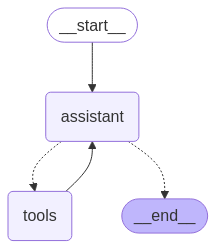

In [4]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_ollama import ChatOllama
from IPython.display import Image, display


# Load the model
llm = ChatOllama(model="qwen2.5:7b", temperature=0.1, max_new_tokens=512)
tools = [immo_info_retriever_tool] # Defining the immo_info_retriever_tool tool
chat_with_tools = llm.bind_tools(tools)


# AgentState and Agent graph
class AgentState(TypedDict):
    # Input data
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

# We create our agent as a StateGraph, that combines 2 nodes (assistant, tools) using an edge
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edgxes: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistant")
immo_assitant_graph = builder.compile()

# Show
display(Image(immo_assitant_graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
immo_assitant_graph.invoke({"messages":"Bonjour, comment ça va ?"})

{'messages': [HumanMessage(content='Bonjour, comment ça va ?', additional_kwargs={}, response_metadata={}, id='bd6a1276-0f44-4387-908a-059d3ac725e2'),
  AIMessage(content="Bonjour ! Je vais bien, merci. Comment puis-je vous aider aujourd'hui ? Est-ce que vous recherchez des informations sur des appartements ou avez-vous une autre question ?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-04-17T14:29:50.122252Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1646803500, 'load_duration': 25283084, 'prompt_eval_count': 181, 'prompt_eval_duration': 262829750, 'eval_count': 38, 'eval_duration': 1350131583, 'model_name': 'qwen2.5:7b'}, id='run-5ac7fcba-969f-4136-9bf1-bf4b84ac6c80-0', usage_metadata={'input_tokens': 181, 'output_tokens': 38, 'total_tokens': 219})]}

In [12]:
messages = [HumanMessage(content="Appartements de plus de 60 m² à Lyon centre avec balcon et prix de vente de plus de 200000 euros avec 2 pièces minim")]
response = immo_assitant_graph.invoke({"messages": messages})

print("Immo Assistant:")
print(response['messages'][-1].content)

Immo Assistant:
Voici un résumé et une comparaison des deux annonces immobilières :

Annonce 1 :
- Localisation : Lyon, 4ème arrondissement
- Surface habitable : 94 m²
- Pièces : 4 chambres
- Orientation : Sud / Ouest
- Année de construction : 2018
- Prix : 350 000 €
- Charges mensuelles : 76 €
- Copropriété : 9 lots
- Taxe foncière : 420 €
- État : Neuf
- Prestations : Climatisation, volets roulants électriques, double vitrage

Annonce 2 :
- Localisation : Lyon, 6ème arrondissement
- Surface habitable : 55 m²
- Pièces : 3 chambres
- Orientation : Est / Ouest
- Année de construction : 1900
- Prix : 215 000 €
- Charges mensuelles : 660 € (copropriété de 25 lots)
- Taxe foncière : 107 €
- État : Ancien, façade refaite en 2016
- Prestations : Volets roulants, porte blindée

Comparaison :
- Localisation : Lyon, arrondissements différents (4ème vs 6ème)
- Taille des logements : Plus grand (94 m²) vs plus petit (55 m²)
- Prix : Plus cher (350 000 €) vs moins cher (215 000 €)
- Charges mensue

In [41]:
for r in response['messages']:
    r.pretty_print()

================================ Human Message =================================

Appartements de plus de 60 m² à Lyon centre avec balcon et prix de vente de plus de 200000 euros avec 2 pièces minim
================================== Ai Message ==================================
Tool Calls:
  immo_info_retriever_tool (42aa4aa9-99d4-4a59-888d-c20e9607ab6a)
 Call ID: 42aa4aa9-99d4-4a59-888d-c20e9607ab6a
  Args:
    query: Appartements de plus de 60 m² à Lyon centre avec balcon et prix de vente de plus de 200000 euros avec 2 pièces minimum
================================= Tool Message =================================
Name: immo_info_retriever_tool

ID: xxseyu
Titre: Appartement • 54,42 m² • 3 pièces • 2 chambres
Prix: 169600.0
Localisation: Lyon 5ème (69005)
Surface: 54.42
Pièces: 3.0
Chambres: 2.0
DPE: e
Description: À VENDRE : Charmant appartement de 54 m² à Lyon.
Découvrez cet appartement lumineux et fonctionnel idéalement situé dans la ville de Lyon. Avec ses 54 m², il offre un cadr

# Agent construction w Memory 

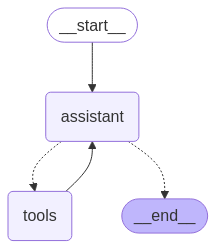

In [6]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_ollama import ChatOllama
from IPython.display import Image, display


# Load the model
llm = ChatOllama(model="qwen2.5:7b", temperature=0.1, max_new_tokens=512)
tools = [immo_info_retriever_tool] # Defining the immo_info_retriever_tool tool
chat_with_tools = llm.bind_tools(tools)


# AgentState and Agent graph
class AgentState(TypedDict):
    # Input data
    messages: Annotated[list[AnyMessage], add_messages]
    memory: List[AnyMessage]  # Add a memory field to store conversation history



def assistant(state: AgentState):
    # Combine current messages with memory
    all_messages = state["memory"] + state["messages"]
    response = chat_with_tools.invoke(all_messages)

    # Update memory with the latest interaction
    state["memory"].extend(state["messages"])
    state["memory"].append(response)

    return {
        "messages": [response],
        "memory": state["memory"]  # Return the updated memory
    }
    
# We create our agent as a StateGraph, that combines 2 nodes (assistant, tools) using an edge
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edgxes: these determine how the control flow moves
builder.add_edge(START, "assistant")


from langgraph.graph import END

def should_continue(state):
    last_message = state["messages"][-1]
    if "tool_calls" in last_message.additional_kwargs:
        return "tools"
    return END  # Or "assistant" for continuous chat

builder.add_conditional_edges(
    "assistant",
    should_continue
)

builder.add_edge("tools", "assistant")
immo_assitant_graph = builder.compile()

# Show
display(Image(immo_assitant_graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

# Define the initial message
initial_messages = [HumanMessage(content="Appartements de plus de 60 m² à Lyon centre avec balcon et prix de vente de plus de 200000 euros avec 2 pièces minim")]

# Initialize the memory with an empty list
state = {
    "messages": initial_messages,
    "memory": []
}

# Function to send a message and update the state
def send_message(state, message_content):
    state["messages"] = [HumanMessage(content=message_content)]
    response = immo_assitant_graph.invoke(state)
    state["memory"] = response["memory"]  # Update memory with the latest interaction
    return response['messages'][-1].content

# Send the initial message
print("Immo Assistant (First Response):")
print(send_message(state, initial_messages[0].content))

# Send the first follow-up message...
follow_up_message_1 = "Pouvez-vous fournir plus de précisions sur les équipements disponibles?"
print("\nImmo Assistant (Follow-Up Response 1):")
print(send_message(state, follow_up_message_1))

# Second...
follow_up_message_2 = "Quels sont les frais de copropriété pour ces appartements?"
print("\nImmo Assistant (Follow-Up Response 2):")
print(send_message(state, follow_up_message_2))

# Continue as needed
follow_up_message_3 = "Est-ce que ces appartements sont proches des transports en commun?"
print("\nImmo Assistant (Follow-Up Response 3):")
print(send_message(state, follow_up_message_3))


for r in response['messages']:
    r.pretty_print()

Immo Assistant (First Response):


KeyError: 'memory'

# Langfuse

In [13]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler(
    trace_name="Real Estate Assistant",
    user_id="admin",  # Replace with actual user/session ID
    metadata={
        "environment": "production",
        "dataset_version": "0.1",
        "retrieval_strategy": "chromadb_l2"
    }
)

# Example input structure for real estate queries
input_payload = {
    "query": "Appartements de plus de 61 m2 à Lyon centre",
    "filters": {
        "max_price": 500000,
        "min_rooms": 2
    }
}

    
legitimate_result = immo_assitant_graph.invoke(
    input=input_payload,
    config={
        "callbacks": [langfuse_handler],
        "metadata": {
            "search_type": "semantic",
            "k_value": 3,
            "model_version": "all-mpnet-base-v2"
        }
    }
)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


In [27]:
vectorstore